# 3.2 Model-Based Predictive Controls
Prepared by (C) Vasken Dermardiros

The objective here is not to teach you optimization or even what is model-based predictive controls. There are just too many excellent references out there, I would not want to embarrass myself by producing low grade explanations.

You can start by reading [this webpage](http://www.me.berkeley.edu/~yzhwang/MPC/optimization.html) made by grad students from Berkeley's [MPC lab](http://www.mpc.berkeley.edu), [this document](http://kom.aau.dk/~mju/downloads/otherDocuments/MPCusingCVX.pdf) demonstrates a simple application that uses [CVX](http://cvxr.com/cvx/) which is in part developed by Prof. Stephen Boyd from Stanford. He also has [his lectures on convex optimization](https://lagunita.stanford.edu/courses/Engineering/CVX101/Winter2014/about) posted online -- free -- along with his co-authored [book](http://www.stanford.edu/~boyd/cvxbook/), which is excellent -- also free.
You can also take a look at [this article](http://www.sciencedirect.com/science/article/pii/S0378778811004105) from the OptiControl team of Switzerland.

What is demo-ed in this notebook is not the "state of the art", it, however, provides an easy way to try a few ideas. If your objective is speed, I suggest you look into using compiled solvers tailored to the problem, *e.g.* [CVXGEN](http://cvxgen.com/docs/index.html), for non-commercial use.

I will start by showing what an optimization looks like since too many throw around that word not knowing what they're talking about. Running 10000 simulations with different parameters and returning the best is **not** an optimization; it's more of a design exploration. In that sense, genetic algorithms cannot guarantee an *optimal* result more so than a very good design. Genetic algorithms are explorative algorithms, whereas optimization is exploitative. A hybrid is possible -- see memetic evolutionary algorithms.

Right after, we will go through 2 simple examples to see how MPC can be used to minimize energy use in a zone. The first example is a simple room with an ideal HVAC system that adds/removes heat directly. The second example uses the same room and, additionally, has a radiant slab system.

### General optimization formulation
$\begin{align}
minimize~ & f(x) \\
subject~to~~ & h_i(x) = 0, & i = 1,...,m  \\
            & g_j(x) >= 0, & j = 1,...,n
\end{align}$

The function $f(x)$ will be minimized while the equality constraints of $h_i(x)$ and inequality constraints of $g_j(x)$ must be satisfied. The function $f(x)$ is refered to as the cost function. The constraints can also be included in the cost function as soft constraints. As soft constraints, they may be violated, but at a high cost; whereas as hard constraints, if a given solution violates the constraints, it is completely rejected.

The solution $x^*$ is called the optimal solution *iff* $f(x^*) \leq f(x)~\forall~x$. (If the equality holds, then more than one optimal exists and $x^*$ is refered to as a soft minimum; otherwise, if there is only one optimal, then it is a hard minimum.)

### Optimization formulation for MPC
Taken from [Oldewurtel *et al.* (2012)](http://www.sciencedirect.com/science/article/pii/S0378778811004105)

<img src="Figures/mpc_eq.png" width=400 align="left"/>

<img src="Figures/mpc_cost.png" width=450 align="left"/>

<img src="Figures/mpc_cons.png" width=450 align="left"/>

---
## Example 1: Simple glazed room, MPC to control ideal HVAC system
Here we are considering a south-facing room with a modest window (WWR: 40%):

<img src="Figures/mpc_room.png" width=250 align="left"/>

As we've done in previous chapters, we will model the room as a thermal network:

<img src="Figures/mpc_network.png" width=350 align="left"/>

The HVAC system is the only variable we can control. We could use On-Off controls, Proportional control, PI, PID, or use a schedule, but they don't explicitely consider thermal mass -- which we will see in the next example.

Let's begin!

### MPC Formulation
What I particularly like about MPC is that the controls are explicit to the user. What is the objective? If it's to reduce the energy dispenditure, make that the cost function. Is it to guarantee a tight temperature control? Make that the cost function. Or maybe it's both? No problem, put them both!

Next come the constraints. You don't want to cycle the heat pump? Make it a constraint! Careful though you don't want to over constrain the optimization so that it fails to find feasible solutions. You can always *soften* constraints into penalties towards the cost function and so violating them just a tad won't lead to a failure in the optimization.

**Cost Function**  
$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
J = \norm{ Q_{\text{HVAC}} }_2$

**Constraints: System Dynamics**  
${\sum}_{j}{[U_{ij}^{v+t+1} (T_{j}^{v+t+1}-T_{i}^{v+t+1})]}+{\sum}_{k}{[U_{ik}^{v+t+1} (T_{k}^{v+t+1}-T_{i}^{v+t+1})]} - \cfrac{C}{\Delta t} (T_{i}^{v+t+1}-T_{v+i}^{t}) + \dot{Q}_{i}^{v+t+1} = 0, \,\,\, v\in[0,ph-1]$

$t$: simulation timestep  
$v$: timestep within prediction horizon  
$ph$: prediction horizon

**Constraints**  
$T^{v+t+1}_{\text{Room}} - T^{v+t+1}_{\text{Heat, SP}} >= 0, \,\,\, v\in[0,ph-1]  \\
T^{v+t+1}_{\text{Cool, SP}} - T^{v+t+1}_{\text{Room}}  >= 0, \,\,\, v\in[0,ph-1]  \\
Q_{\text{Capacity, Heat}} - Q_{\text{HVAC}}^{v+t+1}  >= 0, \,\,\, v\in[0,ph-1]  \\
- Q_{\text{Capacity, Cool}} - Q_{\text{HVAC}}^{v+t+1}  >= 0, \,\,\, v\in[0,ph-1]  \\$

**Other Constraints that can be Considered**  
Limiting the rate of change (slew rate):  
$C_{\text{ROC}} = \norm{ T^{t+1}-T^t }_2$  

Peak power:  
$C_{\text{P}} = \$/kW \cdot \text{max}(\dot{Q}_{\text{A}}^+)$

Energy consumption:  
$C_{\text{E}} = \frac{\$/kWh \cdot \Delta t}{3600} \sum_{t=0}^T \lvert \dot{Q} \lvert$

---------

Onto Python!

### Load Dependencies

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import time
# from tqdm import tqdm # progress bar
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
from IPython import display

# Helper functions to keep this notebook simple and tidy
from code_base import simfun
# from code_base import optfun
# from code_base import load_data

### Simulation Setup

In [2]:
# Steps per hour, number of timesteps, timestep and number of days to simulate
st = 4
nt, dt, days = int(st*24), 3600/st, 1

# Prediction horizon
ph = 8*st  # hours * steps/hour

### Room Model

In [3]:
# Number of nodes: to solve for, with known temperatures, controllable
nN, nM, nS = 1, 1, 1
nSwhere = 1 # which node receives the controlled variable? 0-indexed according to nN
NS = nN + nS
U = np.zeros((nN,nN)) # K/W
F = np.zeros((nN,nM)) # K/W
C = np.zeros((nN))    # J/K

# Nodel connections: here you define how each node is connected to one another
# Node Number: Object
# 0: room air
# No nodal connections between nodes to solve for (only 1!)
# U[0,n] = ...

# Node Number with known temperatures: Object
# 0: ambient air
# Connection between room air node to ambient air node
A, WWR = 3.*4., 0.4
F[0,0] = (    (26.*WWR*A)**-1 +   1.1/(WWR*A) +     (6.*WWR*A)**-1)**-1 + \
         ((26.*(1-WWR)*A)**-1 + 4/((1-WWR)*A) + (6.*(1-WWR)*A)**-1)**-1

# Nodes with capacitance
C[0] = (A*5.)*1.*1.005*40. # 40x multiplier on room capacitance

### Initialize temperature and heat source variables; set initial conditions; set boundary conditions; set limits

In [4]:
T, TK, Q, S = np.zeros((nt*days, nN)), np.zeros((nt*days, nM)), np.zeros((nt*days, nN)), np.zeros((nt*days, nS))
T[:] = np.nan # for clearer plots
S[:] = np.nan # for clearer plots
T[0,] = 17.5
TK[:, 0] = simfun.periodic(-10., 10., 15., 86400., dt, nt, days) # ambient temp
Q[:,0] = simfun.halfperiodic(0.4*A*WWR*800., 12., 86400., dt, nt, days)      # solar gains
Q[:,0] += simfun.linearRamp(450., 400., 17., 9., 0., dt, nt, days).flatten() # internal gains + equip
minS = -5000. # cooling capacity
maxS = 5000.  # heating capacity
#HeatSP = simfun.periodic(16., 5., 15., 86400., dt, nt, days)
#CoolSP = simfun.periodic(20., 5., 15., 86400., dt, nt, days)
HeatSP = simfun.linearRamp(21., 5., 18., 6., 0., dt, nt, days)
CoolSP = simfun.linearRamp(26.,-5., 18., 6., 0., dt, nt, days)

### Constraints

In [5]:
def getConstraints(i, cons):
    # Current State
    if i == 0:
        cons.append({'type': 'eq', 'fun': lambda x: x[0] - T[ct,0]},)
        
    # System Dynamics
    cons.append({'type': 'eq', 'fun': lambda x:
                 F[0,0]*(TK[ct+i+1,0]-x[NS*(i+1)]) -
                 C[0]*(x[NS*(i+1)]-x[NS*i]) +
                 x[NS*i+nN] +
                 Q[ct+i+1,0] },)
    
    # Constraints
    cons.append({'type': 'ineq', 'fun': lambda x: CoolSP[ct+i+1] - x[NS*(i+1)]},)
    cons.append({'type': 'ineq', 'fun': lambda x: x[NS*(i+1)] - HeatSP[ct+i+1]},)
    cons.append({'type': 'ineq', 'fun': lambda x: maxS - x[NS*i+nN]},)
    cons.append({'type': 'ineq', 'fun': lambda x: x[NS*i+nN] - minS},)
    return cons

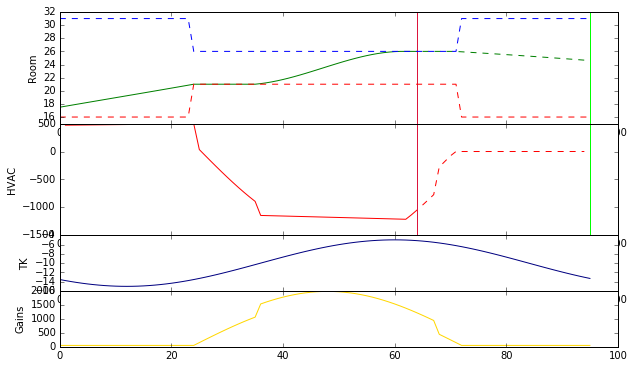

Elapsed time: 71.2051119804


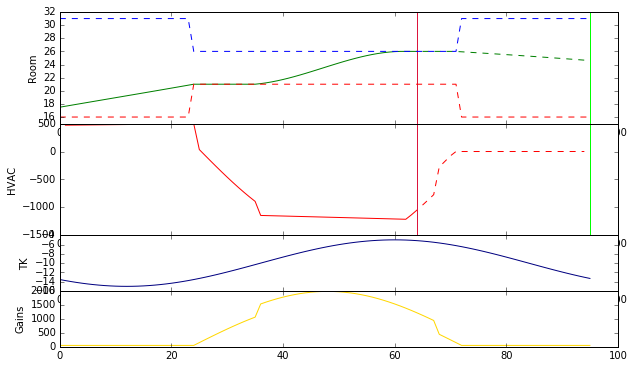

In [6]:
timer = time.time()
optRng = range(days*nt-ph)
for ct in optRng:
    # Cost function
    costfun = lambda x: np.linalg.norm(x[(nN):-(nN+nS):(nN+nS)]) # minimize heat input
    
    # Initial guess for ct=0, warm start with previous optimal for rest
    if ct ==0: x0 = np.zeros((ph,nN+nS)).reshape(-1,1)
    else: x0 = np.vstack((res.x[(nN+nS)::].reshape(-1,1), np.zeros((nN+nS,1))))
        
    # Constraints; loop through prediction steps and get constraints for every timestep
    cons = []
    for i in range(ph-1):
        getConstraints(i, cons)
    cons = tuple(cons)
    
    # Run optimization
    res = minimize(costfun, x0, method='SLSQP', constraints=cons,
                   options={'ftol': 1e-3, 'disp': False, 'maxiter': 50})
    
    # Break on error
    if res.status != 0:
        print "Optimization Failed!"
        print "Timestep: %i, Reason: %i"%(ct,res.status)
        break
        
    # Sort and store results
    T[ct+1,] = res.x[nN+nS:2*nN+nS]
    S[ct+1,] = res.x[nN:nN+nS]
    tempT = res.x.reshape(-1,NS)[2:,0:nN]
    tempS = res.x.reshape(-1,NS)[1:-1,nN:nN+nS]
    del cons
    
    # Plot
    ax1 = plt.subplot2grid((6,1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((6,1), (2, 0), rowspan=2, sharex=ax1)
    ax3 = plt.subplot2grid((6,1), (4, 0), sharex=ax1)
    ax4 = plt.subplot2grid((6,1), (5, 0), sharex=ax1)
    ax1.hold(True)
    ax1.plot(T,'g')
    ax1.plot(range(ct+2,ct+ph),tempT, 'g--')
    ax1.axvline(ct+1, color='crimson') # draw control horizon
    ax1.axvline(ct+ph, color='lime')   # draw prediction horizon
    ax1.plot(HeatSP,'r--')
    ax1.plot(CoolSP,'b--')
    ax1.set_ylim([15,32])
    ax1.set_ylabel('Room')
    ax2.plot(S,'r')
    ax2.plot(range(ct+2,ct+ph),tempS, 'r--')
    ax2.axvline(ct+1, color='crimson') # draw control horizon
    ax2.axvline(ct+ph, color='lime')   # draw prediction horizon
    ax2.set_ylabel('HVAC')
    ax3.plot(TK, color='navy')
    ax3.set_ylabel('TK')
    ax4.plot(Q, color='gold')
    ax4.set_ylabel('Gains')
    plt.subplots_adjust(hspace=0)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
print "Elapsed time: %s" % (time.time()-timer)

---